# Precios de inmuebles

### Objetivo

Generar un modelo que prediga de forma adecuada los precios de inmuebles en la ciudad de Ames, Iowa. Utilizaremos un dataset conocido (ames_housing.csv) e implementaremos el algoritmo de ensamble de Árboles de Decisión para modelar.

Puesto que intentamos predecir precios y no rangos de precios, utilizaremos específicamente **Decision Tree Regressor**,

## Preparación del ambiente de trabajo

In [1]:
# librerías clásicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

# para el modelo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

Importamos el dataset y borramos la columna $\texttt{Unnamed: 0}$.

In [2]:
df = pd.read_csv("ames_housing.csv").drop("Unnamed: 0", axis = 1)

Nos queda inicialmente:

In [3]:
df.head()

MS_SubClass                 MS_Zoning  \
0  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
1  One_Story_1946_and_Newer_All_Styles  Residential_High_Density   
2  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
3  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
4             Two_Story_1946_and_Newer   Residential_Low_Density   

   Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
0           141     31770   Pave  No_Alley_Access  Slightly_Irregular   
1            80     11622   Pave  No_Alley_Access             Regular   
2            81     14267   Pave  No_Alley_Access  Slightly_Irregular   
3            93     11160   Pave  No_Alley_Access             Regular   
4            74     13830   Pave  No_Alley_Access  Slightly_Irregular   

  Land_Contour Utilities Lot_Config  ...            Fence Misc_Feature  \
0          Lvl    AllPub     Corner  ...         No_Fence         None   
1          Lvl    AllPub     Inside  ...  Minimum_Privacy         None   
2          Lvl    AllPub     Corner  ...         No_Fence         Gar2   
3          Lvl    AllPub     Corner  ...         No_Fence         None   
4          Lvl    AllPub     Inside  ...  Minimum_Privacy         None   

  Misc_Val Mo_Sold Year_Sold Sale_Type Sale_Condition Sale_Price  Longitude  \
0        0       5      2010       WD          Normal     215000 -93.619754   
1        0       6      2010       WD          Normal     105000 -93.619756   
2    12500       6      2010       WD          Normal     172000 -93.619387   
3        0       4      2010       WD          Normal     244000 -93.617320   
4        0       3      2010       WD          Normal     189900 -93.638933   

    Latitude  
0  42.054035  
1  42.053014  
2  42.052659  
3  42.051245  
4  42.060899  

[5 rows x 81 columns]

Tamaño de la muestra:

In [4]:
print(f"Registros: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")

Registros: 2930
Columnas: 81


Posibles valores perdidos en la muestra:

In [5]:
df.isna().sum().value_counts()

0    81
dtype: int64

No existen valores perdidos en el dataset.

## Feature engineering

Inspeccionamos el tipo de dato de cada columna.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

En resumen, tenemos

In [7]:
df.dtypes.value_counts()

object     46
int64      33
float64     2
dtype: int64

Tenemos $46$ variables categóricas y $35$ numéricas. Separamos los nombres de las columnas categóricas a un array para después aplicar $\texttt{Binary Encoding}$ con la función $\texttt{get_dummies}$().

Definimos la variable $\texttt{count}$ inicializada en el valor total de variables numéricas. A esta variable le sumamos la cantidad de columnas nuevas que deberían sumarse al dataset, considerando que la primera se elimina.

In [8]:
df_categorical_cols = []
count = 35

for col in df.select_dtypes("O"):
    df_categorical_cols.append(col)
    count += (df[col].nunique() - 1)  # se agregan K-1 columnas nuevas

In [9]:
df_categorical_cols[:6]

['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour']

Aplicamos la función $\texttt{get_dummies}$() al df original para las columnas seleccionadas. Aplicamos el atributo $\texttt{drop_first}$ para borrar la primera columna.

In [10]:
df = pd.get_dummies(df, columns = df_categorical_cols, drop_first = True)

Observamos que el valor obtenido en $\texttt{count}$ es el mismo que la nueva cantidad de columnas del dataset.

In [11]:
count == df.shape[1]

True

Nos queda como df definitivo:

In [12]:
df.head()

Lot_Frontage  Lot_Area  Year_Built  Year_Remod_Add  Mas_Vnr_Area  \
0           141     31770        1960            1960           112   
1            80     11622        1961            1961             0   
2            81     14267        1958            1958           108   
3            93     11160        1968            1968             0   
4            74     13830        1997            1998             0   

   BsmtFin_SF_1  BsmtFin_SF_2  Bsmt_Unf_SF  Total_Bsmt_SF  First_Flr_SF  ...  \
0             2             0          441           1080          1656  ...   
1             6           144          270            882           896  ...   
2             1             0          406           1329          1329  ...   
3             1             0         1045           2110          2110  ...   
4             3             0          137            928           928  ...   

   Sale_Type_ConLw  Sale_Type_New  Sale_Type_Oth  Sale_Type_VWD  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   

   Sale_Type_WD   Sale_Condition_AdjLand  Sale_Condition_Alloca  \
0              1                       0                      0   
1              1                       0                      0   
2              1                       0                      0   
3              1                       0                      0   
4              1                       0                      0   

   Sale_Condition_Family  Sale_Condition_Normal  Sale_Condition_Partial  
0                      0                      1                       0  
1                      0                      1                       0  
2                      0                      1                       0  
3                      0                      1                       0  
4                      0                      1                       0  

[5 rows x 307 columns]

## Primer modelo

Hacemos la separación de la muestra:

In [13]:
X_mat = df.drop('Sale_Price', axis = 1)
y_vec = df['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size = .33, random_state = 1504)

Entrenamos el árbol de regresión en la muestra de entrenamiento sin modificar los hiperparámetros.

In [14]:
dec_tree = DecisionTreeRegressor(random_state = 281)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=281)

Luego, reportamos las métricas de desempeño:

In [15]:
ypred_dec_tree = dec_tree.predict(X_test)

MSE_dec_tree = mean_squared_error(y_test, ypred_dec_tree)
RMSE_dec_tree = np.sqrt(MSE_dec_tree).round(5)

MAE_dec_tree = median_absolute_error(y_test, ypred_dec_tree.round(5))

R2_dec_tree = r2_score(y_test, ypred_dec_tree.round(5))

In [16]:
print(f"Test RMSE: {np.round(RMSE_dec_tree, 3)}")
print(f"Test MAE: {np.round(MAE_dec_tree, 3)}")
print(f"Test R2: {np.round(R2_dec_tree, 3)}")

Test RMSE: 37104.288
Test MAE: 15500.0
Test R2: 0.783


Si comparamos las métricas $\textsf{RMSE}$ y $\textsf{MAE}$ con el promedio del vector objetivo $\textsf{Sale_Price}$ obtenemos:

In [17]:
print(f"RMSE/Ymean: {np.round(RMSE_dec_tree/df['Sale_Price'].mean(), 3)}")

RMSE/Ymean: 0.205


In [18]:
print(f"MAE/Ymean: {np.round(MAE_dec_tree/df['Sale_Price'].mean(), 3)}")

MAE/Ymean: 0.086


Observamos que el valor obtenido para $\textsf{RMSE}$ alcanza un $20.5\%$ de la media del vector objetivo, mientras que el $\textsf{MAE}$ un $8.6\%$.

Esto sumado a un $R^2$ que explica en un $78.3\%$ la variación de $\textsf{Sale_Price}$, vemos que el modelo no tiene un desempeño excelente, pero tampoco malo.

## Importancia relativa

Extraemos el método $\texttt{plot_importance}$() de los archivos utilizados en la lectura para reportar la importancia relativa de los atributos.

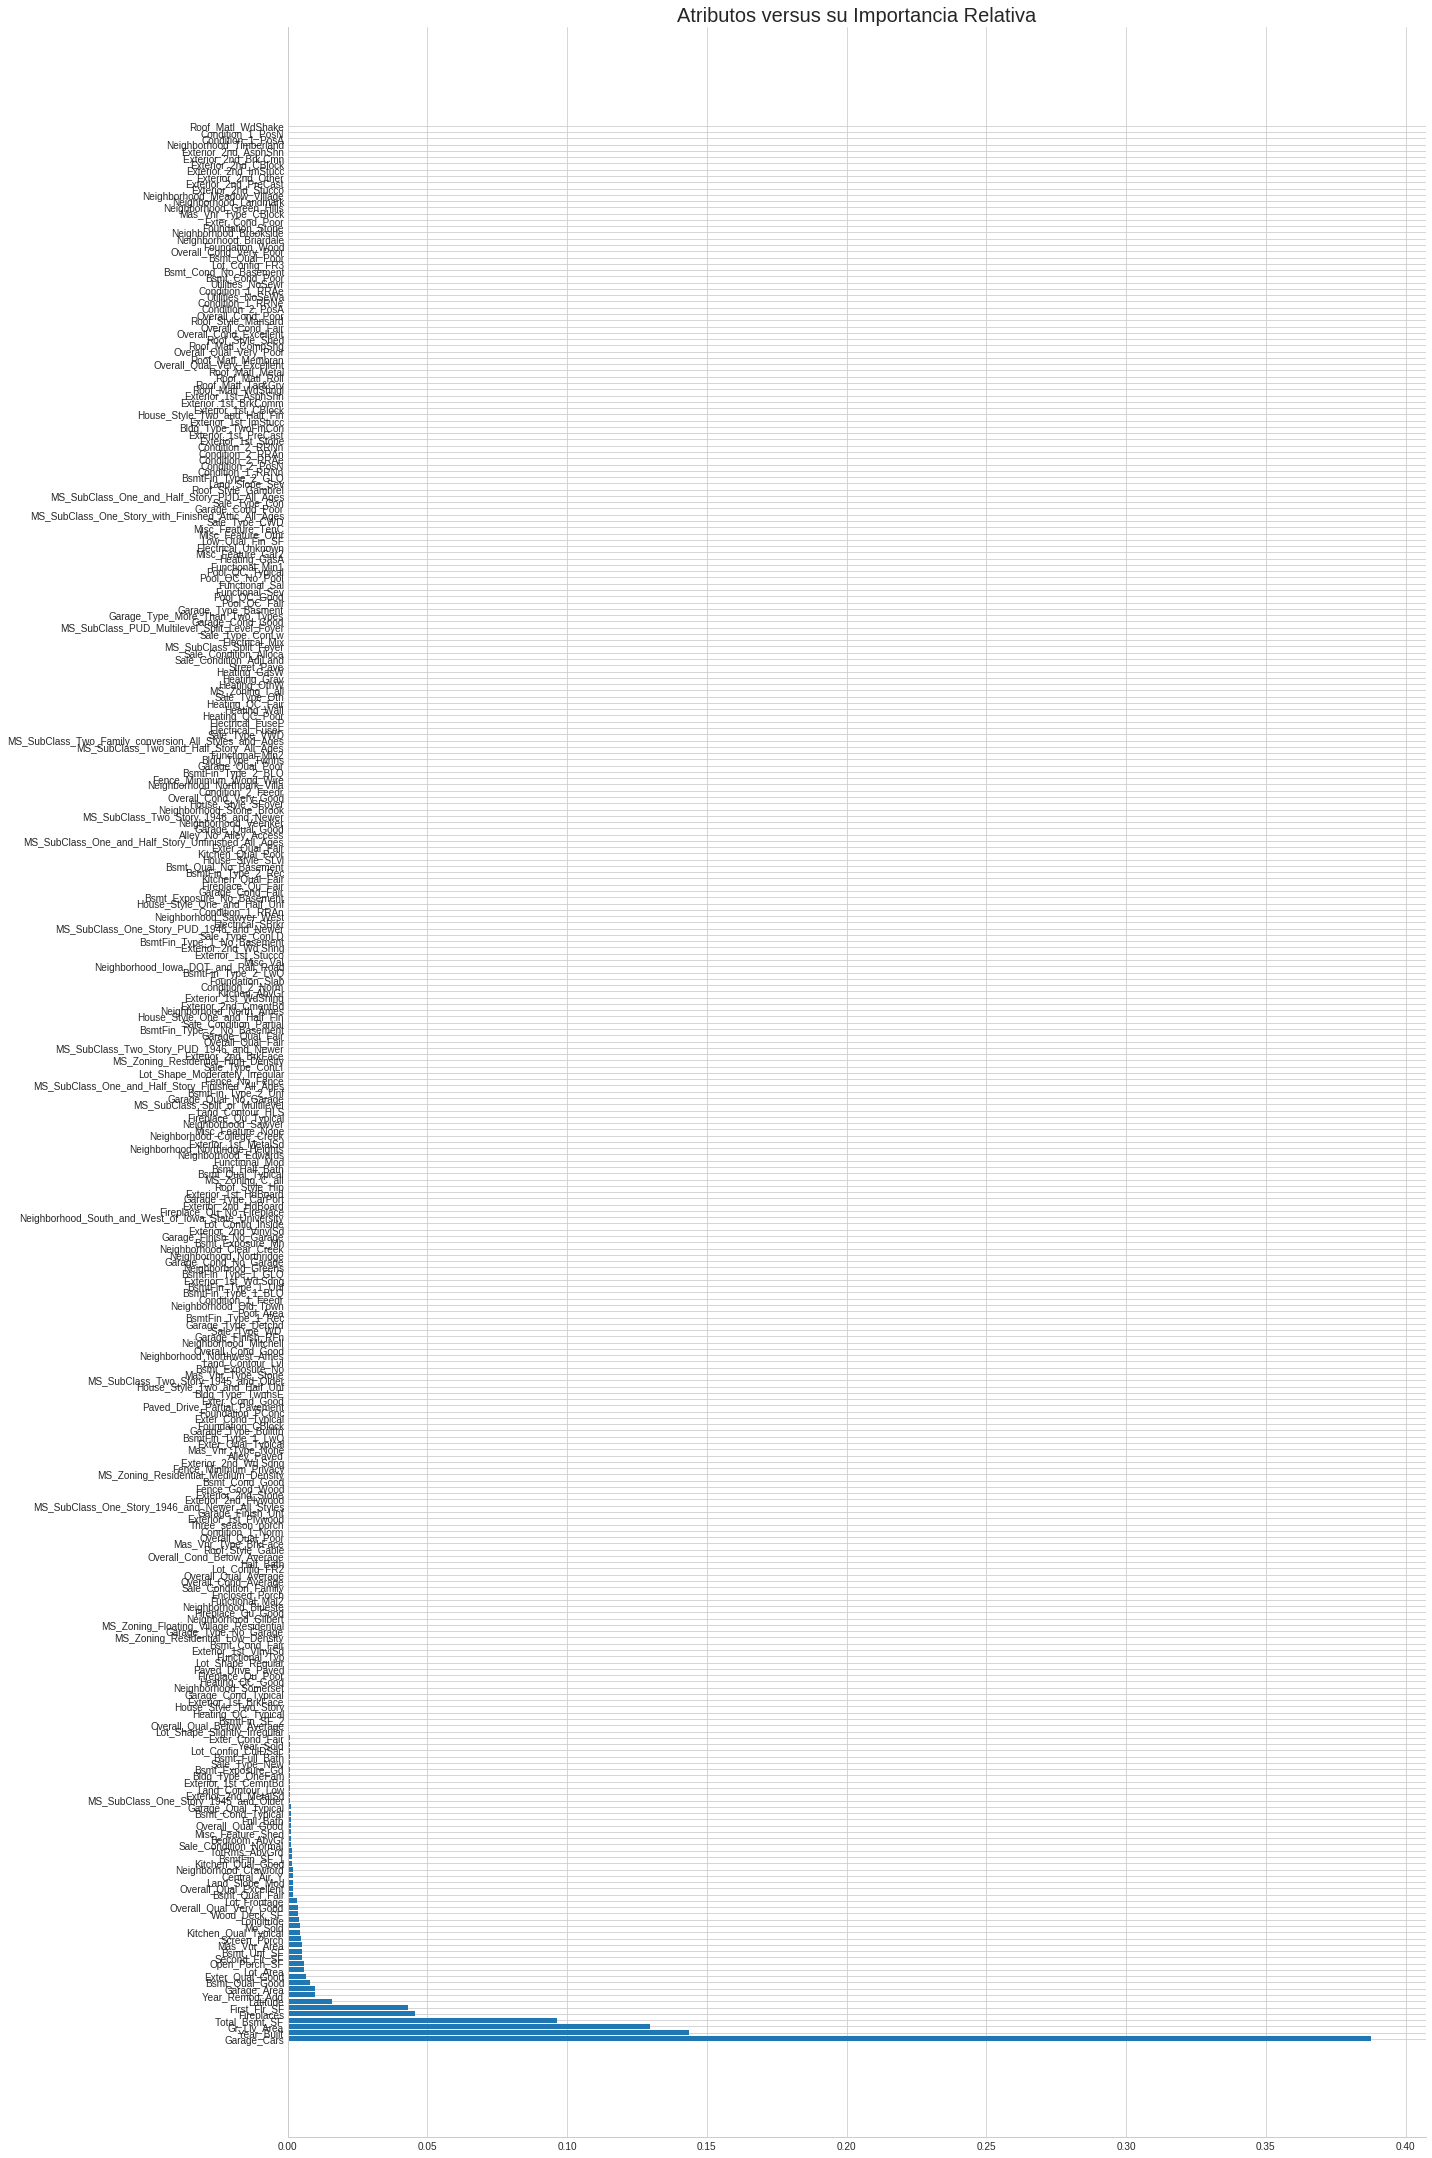

In [19]:
def plot_importance(fit_model, feat_names):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(len(feat_names)), tmp_importance[sort_importance])
    plt.yticks(range(len(feat_names)), names, rotation = 0)
    plt.tight_layout()
    
plt.figure(figsize = (20, 30))

plot_importance(dec_tree, X_mat.columns)
plt.title("Atributos versus su Importancia Relativa", fontsize = 20);
sns.despine()

Refactorizamos la función incorporada para rescatar los $10$ atributos que afectan más la predicción del vector objetivo y graficamos.

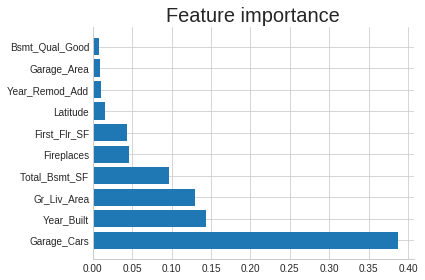

In [20]:
topten_cols = []  # array global donde se guardan los principales atributos

def plot_most_important(fit_model, feat_names, n_attr = 10):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    sort_importance_n = sort_importance[:n_attr]
    names_n = [feat_names[i] for i in sort_importance_n]
    
    for i in names_n: topten_cols.append(i)
    
    plt.title("Feature importance", fontsize = 20)
    plt.barh(range(n_attr), tmp_importance[sort_importance_n])
    plt.yticks(range(n_attr), names_n, rotation = 0)
    plt.tight_layout()
    sns.despine()

plot_most_important(dec_tree, X_mat.columns)

Tomamos estos atributos, sumamos el nombre del vector objetivo y los rescatamos en un nuevo archivo de datos.

In [21]:
topten_cols.append('Sale_Price')

topten_df = df.loc[:, topten_cols]

Nos queda:

In [22]:
topten_df.head()

Garage_Cars  Year_Built  Gr_Liv_Area  Total_Bsmt_SF  Fireplaces  \
0            2        1960         1656           1080           2   
1            1        1961          896            882           0   
2            1        1958         1329           1329           0   
3            2        1968         2110           2110           2   
4            2        1997         1629            928           1   

   First_Flr_SF   Latitude  Year_Remod_Add  Garage_Area  Bsmt_Qual_Good  \
0          1656  42.054035            1960          528               0   
1           896  42.053014            1961          730               0   
2          1329  42.052659            1958          312               0   
3          2110  42.051245            1968          522               0   
4           928  42.060899            1998          482               1   

   Sale_Price  
0      215000  
1      105000  
2      172000  
3      244000  
4      189900

## Refactorización del modelo

Generamos conjuntos de entrenamiento y prueba con el nuevo df.

In [23]:
X_mat_rf = topten_df.drop('Sale_Price', axis = 1)
y_vec_rf = topten_df['Sale_Price']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_mat_rf, y_vec_rf,
                                                                test_size = .33,
                                                                random_state = 1504)

Establecemos los hiperparámetros para generar la búsqueda de grilla con $\texttt{GridSearch}$()

In [24]:
params = {'max_features': list(range(1, X_train_rf.shape[1] + 1)), 
          'max_depth': np.linspace(1, 32, 32)}

In [25]:
%%time

gsCV_decTree = GridSearchCV(DecisionTreeRegressor(random_state = 281), params,
                            cv = 5, n_jobs = -1).fit(X_train_rf, y_train_rf)

CPU times: user 1.59 s, sys: 136 ms, total: 1.72 s
Wall time: 4.53 s


Obtenermos que la mejor combinación de hiperparámetros se da con:

In [26]:
print(f"max_depth: {gsCV_decTree.best_params_['max_depth']}")
print(f"max_features: {gsCV_decTree.best_params_['max_features']}")

max_depth: 8.0
max_features: 7


Y su respectivo desempeño:

In [27]:
print(f"Best Score: {np.round(gsCV_decTree.best_score_, 3)}")

Best Score: 0.806


El mejor modelo estaría dado entonces por:

In [28]:
best_model = gsCV_decTree.best_estimator_
best_model

DecisionTreeRegressor(max_depth=8.0, max_features=7, random_state=281)

Reportamos sus métricas de desempeño:

In [29]:
best_ypred = best_model.predict(X_test_rf)

best_MSE = mean_squared_error(y_test_rf, best_ypred)
best_RMSE = np.sqrt(best_MSE).round(5)

best_MAE = median_absolute_error(y_test_rf, best_ypred.round(5))

best_R2 = r2_score(y_test_rf, best_ypred.round(5))

In [30]:
print(f"Best RMSE: {np.round(best_RMSE, 3)}")
print(f"Best MAE: {np.round(best_MAE, 3)}")
print(f"Best R2: {np.round(best_R2, 3)}")

Best RMSE: 37396.165
Best MAE: 15468.4
Best R2: 0.78


Sabemos que un modelo se ajusta mejor cuando $\textsf{RMSE}$ y $\textsf{MAE}$ son más bajos y cuando $R^2$ es más cercano a $1$.

En este caso, esto se cumple sólo para el $\textsf{MAE}$, aunque sus valores no son muy diferentes que el del modelo sin hiperparámetros. Y el $R^2$ también, pues el modelo ahora explica con un $78\%$ la variación del vector objetivo ($0.3\%$ menos que el modelo sin hiperparámetros). tal vez un $\textsf{max_depth}$ más bajo mejoraría los resultados.